In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sepp.sepp_grid
import open_cp.sources.chicago
import open_cp.geometry
import descartes
import pickle, lzma, datetime
import open_cp.predictors
import open_cp.kernels

In [3]:
datadir = os.path.join("..", "..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
open_cp.sources.chicago.set_data_directory(datadir)

with lzma.open(os.path.join(datadir, "chicago_all.csv.xz"), "rt") as file:
    all_points = open_cp.sources.chicago.load(file, "BURGLARY", type="all")

In [4]:
northside = open_cp.sources.chicago.get_side("Southwest")
grid = open_cp.data.Grid(150, 150, 0, 0)
grid = open_cp.geometry.mask_grid_by_intersection(northside, grid)

In [5]:
mask = (all_points.timestamps >= np.datetime64("2016-01-01")) & (all_points.timestamps < np.datetime64("2017-01-01"))
points = all_points[mask]
print(points.number_data_points)
points = open_cp.geometry.intersect_timed_points(points, northside)
print(points.number_data_points)

13620
2507


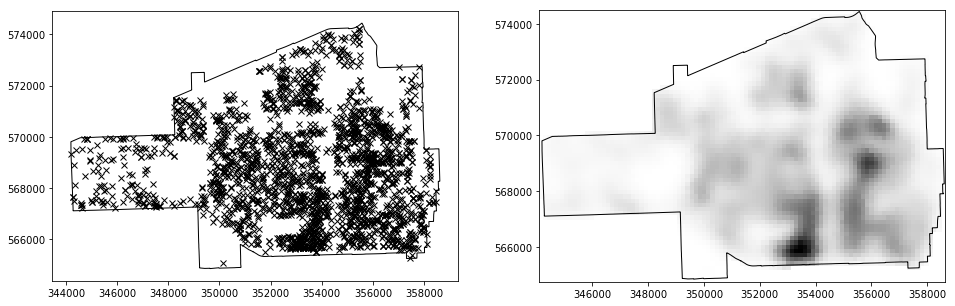

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(16,10))

ax = axes[0]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.scatter(points.xcoords, points.ycoords, marker="x", color="black", linewidth=1)

kernel = open_cp.kernels.GaussianBase(points.coords)
kernel.bandwidth = 300
kernel.covariance_matrix = [[1,0], [0,1]]
pred = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, grid, samples=5)
ax = axes[1]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
None

In [7]:
trainer = sepp.sepp_grid.ExpDecayTrainer(grid)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)

C:\Users\Matthew\Documents\m_drive\GitHub\sepp\sepp\sepp_grid.py:276: RuntimeWarning: divide by zero encountered in double_scalars
  return over / under
C:\Users\Matthew\Documents\m_drive\GitHub\sepp\sepp\sepp_grid.py:338: RuntimeWarning: invalid value encountered in multiply
  return _np.exp(- self._omega * tdelta) * self._omega * self._theta


In [8]:
cells = trainer.to_cells(datetime.datetime(2017,1,1))

In [9]:
cells.shape

(65, 97)

In [10]:
cells, model = trainer.initial_model(datetime.datetime(2017,1,1))
model

ExpDecayModel(T=365.8541666666667, theta=0.5, omega=1.0, mu size=(65, 97)

In [11]:
for _ in range(50):
    opt = sepp.sepp_grid.ExpDecayOptFast(model, cells)
    model = opt.optimised_model()
    print(model)

ExpDecayModel(T=365.8541666666667, theta=0.043962030497078544, omega=0.6574172339760306, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=0.02979077940825713, omega=0.7829843706597214, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=0.02416722052752962, omega=1.0453570645089796, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=0.02135609445043436, omega=1.4968165035048495, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=0.01971421971169406, omega=2.292373257011215, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=0.018606805701136542, omega=3.694226765066541, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=0.017730053599323253, omega=5.742734250022031, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=0.01689280593859734, omega=8.144910500334428, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=0.016143767245389486, omega=10.406776516794032, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=0.015497242703

C:\Users\Matthew\Documents\m_drive\GitHub\sepp\sepp\sepp_grid.py:276: RuntimeWarning: divide by zero encountered in double_scalars
  return over / under
C:\Users\Matthew\Documents\m_drive\GitHub\sepp\sepp\sepp_grid.py:338: RuntimeWarning: invalid value encountered in multiply
  return _np.exp(- self._omega * tdelta) * self._omega * self._theta


ExpDecayModel(T=365.8541666666667, theta=0.0063821298743110995, omega=inf, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=nan, omega=nan, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=nan, omega=nan, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=nan, omega=nan, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=nan, omega=nan, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=nan, omega=nan, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=nan, omega=nan, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=nan, omega=nan, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=nan, omega=nan, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=nan, omega=nan, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=nan, omega=nan, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=nan, omega=nan, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=nan, omega=nan, mu size=(65, 97)
ExpDecayModel(T=365.

### Add a random pertubation to the timestamps

So long as we remember to re-order, this works fine.

In [12]:
cells, model = trainer.initial_model(datetime.datetime(2017,1,1))
new_cells = []
for cell in cells.flat:
    if len(cell) > 0:
        cell += np.random.random(size=len(cell)) * 0.1
        cell.sort()
        assert all(x<0 for x in cell)
    new_cells.append(cell)
cells = np.asarray(new_cells).reshape(cells.shape)

In [13]:
for _ in range(50):
    opt = sepp.sepp_grid.ExpDecayOptFast(model, cells)
    model = opt.optimised_model()
    print(model)

ExpDecayModel(T=365.8541666666667, theta=0.0439047424544021, omega=0.6556132355158384, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=0.029744103241334884, omega=0.778637998004762, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=0.024124212114204374, omega=1.0348517239302761, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=0.021322832260979453, omega=1.4688498696731802, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=0.019703497928881375, omega=2.206239145038302, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=0.01862239996757067, omega=3.422388799359174, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=0.01777300365975117, omega=5.064391186901344, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=0.016985409712921555, omega=6.8436825923804685, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=0.016333288729616258, omega=8.422684802366588, mu size=(65, 97)
ExpDecayModel(T=365.8541666666667, theta=0.015847445204

## Check the cause of the repeated timestamp...

In [14]:
import impute.chicago
import shapely.geometry

In [15]:
def gen():
    with lzma.open(os.path.join(datadir, "chicago_all.csv.xz"), "rt") as file:
        yield from impute.chicago.load_only_with_point(file)
next(gen())

Row(id='5189091', crime_type='OFFENSE INVOLVING CHILDREN', crime_subtype='CHILD ABUSE', location='RESIDENCE', address='108XX S AVENUE G', datetime=datetime.datetime(2006, 10, 12, 10, 58), point=(-87.531655723, 41.698387427))

In [16]:
proj = impute.chicago.projector()
rows = []
for row in gen():
    in_time_range = row.datetime >= datetime.datetime(2016,1,1) and row.datetime < datetime.datetime(2017,1,1)
    if in_time_range and row.crime_type=="BURGLARY":
        point = shapely.geometry.Point(*proj(*row.point))
        if northside.intersects(point):
            rows.append(row)
rows.sort(key = lambda row : row.datetime)
len(rows)

2507

In [18]:
points.number_data_points

2507

In [30]:
cells = np.empty((grid.yextent, grid.xextent), dtype=np.object)
for x in range(grid.xextent):
    for y in range(grid.yextent):
        cells[y, x] = list()
for row in rows:
    x, y = grid.grid_coord(*proj(*row.point))
    cells[y,x].append(row)

In [32]:
[x for x in cells.flat if len(x)>10]

[[Row(id='10381316', crime_type='BURGLARY', crime_subtype='HOME INVASION', location='APARTMENT', address='050XX S RACINE AVE', datetime=datetime.datetime(2016, 1, 15, 22, 30), point=(-87.655082078, 41.802428443)),
  Row(id='10384788', crime_type='BURGLARY', crime_subtype='FORCIBLE ENTRY', location='RESIDENCE', address='050XX S ELIZABETH ST', datetime=datetime.datetime(2016, 1, 19, 2, 0), point=(-87.656299951, 41.802408184)),
  Row(id='10386095', crime_type='BURGLARY', crime_subtype='FORCIBLE ENTRY', location='APARTMENT', address='050XX S ELIZABETH ST', datetime=datetime.datetime(2016, 1, 20, 19, 45), point=(-87.656305321, 41.802594827)),
  Row(id='10404073', crime_type='BURGLARY', crime_subtype='FORCIBLE ENTRY', location='APARTMENT', address='050XX S ELIZABETH ST', datetime=datetime.datetime(2016, 1, 20, 19, 55), point=(-87.656305321, 41.802594827)),
  Row(id='10420937', crime_type='BURGLARY', crime_subtype='FORCIBLE ENTRY', location='RESIDENCE', address='050XX S ELIZABETH ST', datetim

So we see here two exact repeats (with the same coordinates, not just the same grid cells).

An examination of the raw CSV files shows these have different "Case Number"s as well.

It is hard to know, but given that times are probably estimates and/or rounded, and that address is to the block only, and that we believe the location is somewhat random, we probably feel that these are "near repeats" not exact repeats.